This notebook experiment with running PM between SAR1 predicted and SAR1 real forward way and backwards.

I want to find out why border noise appears at the adges when reverse way ran?

# Imort modules and data

In [20]:
# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
import os 
from datetime import datetime
import seaborn as sns


%matplotlib inline


In [21]:
from nansat import NSR

from sea_ice_drift.ftlib import feature_tracking
import sys
sys.path.append(r'./modules/sea_ice_drift')
from pmlib_with_ssim import pattern_matching

In [22]:
import warping_with_domain

ModuleNotFoundError: No module named 'warping_with_domain'

In [23]:
# Extract results arrays

# Define the path to the parent directory
parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/51-82_reverse_pm_for_distortion_experiment'

In [24]:
# Defining domain importing X and Y for subset (it's mutual for all pairs)
import sys
sys.path.append("./modules")

from nansat import Nansat, Domain, NSR
from config import proj4, srs


npz_file_path = os.path.join(parent_dir,  "domain_output.npz")
npz_data = np.load(npz_file_path)

    
X = npz_data['X']
Y = npz_data['Y']

mod_res = 2500
mod_dom = Domain(srs, f'-te {min(X.data)} {min(Y.data) - mod_res * 2} {max(X.data) + mod_res} {max(Y.data)} -tr {mod_res} {mod_res}')
lon1pm, lat1pm = mod_dom.get_geolocation_grids()
x, y = mod_dom.get_geolocation_grids(dst_srs=srs)
dst_res = 100
dst_dom = Domain(srs, f'-te {min(X.data)} {min(Y.data) - dst_res * 2} {max(X.data) + dst_res} {max(Y.data)} -tr {dst_res} {dst_res}')
x100, y100 = dst_dom.get_geolocation_grids(dst_srs=srs)

In [25]:
def export_pm_output_data(parent_dir, vars_folder_name, file_name, variable_names):
    """
    Extracts pattern matching output variables from .npz files in subdirectories of a parent directory.
    
    Args:
    parent_dir (str): The path to the parent directory containing subdirectories.
    vars_folder_name (str): The name of the folder within each subdirectory that contains the .npz file.
    **kwargs: Keyword arguments specifying the variable names to extract from the .npz files.
    
    The possible key variables to extract and their descriptions are:
    - upm: Eastward ice drift displacement in destination SRS units.
    - vpm: Northward ice drift displacement in destination SRS units.
    - apm: Angle that gives the highest MCC (Maximum Cross Correlation).
    - rpm: Maximum cross correlation (MCC) value.
    - hpm: Hessian of the cross-correlation at the MCC point.
    - ssim: Similarity index between the two images for each point.
    - lon2pm: Longitude of results on image 2.
    - lat2pm: Latitude of results on image 2.
    - gpi1: Mask of good pixels after filtering with the hessian.
    - gpi2: Mask of good pixels after filtering with the hessian and number of neighboring pixels.
    - model_u - Eastward model ice drift displacement in destination SRS units.
    - model_v - Northward model ice drift displacement in destination SRS units.
    
    Returns:
    dict: A dictionary containing lists of extracted data for each specified variable.
    list: A list of timestamps extracted from the folder names.
    """
    
    # Initialize a dictionary to hold lists for each variable
    data_dict = {var: [] for var in variable_names}
    timestamps = []

    # Iterate through subdirectories (folders for each pair)
    for subdir in os.listdir(parent_dir):
        sub_dir_path = os.path.join(parent_dir, subdir)

        # Check if the .npz file exists
        npz_file_path = os.path.join(sub_dir_path, vars_folder_name, f'{file_name}.npz')
        if os.path.exists(npz_file_path):
            # Load the contents of the .npz file
            npz_data = np.load(npz_file_path)
            

            # Extract and append parameters to their respective lists in the dictionary
            for var in variable_names:
                if var in npz_data:
                    data_dict[var].append(npz_data[var])

            # Extract and append the timestamps from folder names
            timestamps.append(subdir)

    # Return the dictionary and the timestamps
    return data_dict, timestamps


def calculate_mean_distor_parameters(timestamps, rpm_list, hpm_list, ssim_list, gpi_list=None):
    """
    Calculates the mean, minimum, and maximum values for various distortion parameters 
    for each timestamp and optionally filters the data based on a good pixel index list.

    Parameters:
    timestamps (list): List of timestamps corresponding to each set of data.
    rpm_list (list): List of RPM (Maximum Cross Correlation) values for each timestamp.
    hpm_list (list): List of HPM (Hessian of Cross-Correlation at MCC point) values for each timestamp.
    ssim_list (list): List of SSIM (Similarity Index) values for each timestamp.
    gpi (list, optional): List of good pixel index masks to filter the data. 
                               If None, no filtering is applied.

    Returns:
    dict: A dictionary containing the following keys and their corresponding list of values:
        - 'rpm_mean': Mean values of RPM.
        - 'rpm_min': Minimum values of RPM.
        - 'rpm_max': Maximum values of RPM.
        - 'hpm_mean': Mean values of HPM.
        - 'hpm_min': Minimum values of HPM.
        - 'hpm_max': Maximum values of HPM.
        - 'ssim_mean': Mean values of SSIM.
        - 'ssim_min': Minimum values of SSIM.
        - 'ssim_max': Maximum values of SSIM.
    
    Each key in the dictionary corresponds to a specific statistic (mean, min, max) for each parameter (RPM, HPM, SSIM).
    """
    
    # Initialize a dictionary to store statistics for each parameter
    statistics = {
        'rpm_mean': [], 'rpm_min': [], 'rpm_max': [],
        'hpm_mean': [], 'hpm_min': [], 'hpm_max': [],
        'ssim_mean': [], 'ssim_min': [], 'ssim_max': []
    }
    
    true_count_list = [] 
    # Iterate through the pairs and calculate statistics
    for i in range(len(timestamps)):
        # Calculate number of good pixelas for further normalization
        true_count = np.count_nonzero(gpi2_list[i])
        true_count_list.append(true_count)
        
        # Determine data based on whether gpi_list is defined
        rpm_data = rpm_list[i] if gpi_list is None else rpm_list[i][gpi_list[i]]
        hpm_data = hpm_list[i] if gpi_list is None else hpm_list[i][gpi_list[i]]
        ssim_data = ssim_list[i] if gpi_list is None else ssim_list[i][gpi_list[i]]

        # Calculate and append statistics for RPM, HPM, and SSIM
        for param, data in zip(['rpm', 'hpm', 'ssim'], [rpm_data, hpm_data, ssim_data]):
            mean = round(np.nanmean(data), 2)
            min_val = round(np.nanmin(data), 2)
            max_val = round(np.nanmax(data), 2)
            
            statistics[f'{param}_mean'].append(mean)
            statistics[f'{param}_min'].append(min_val)
            statistics[f'{param}_max'].append(max_val)

        # Print the calculated statistics for the current pair
        print(f"Pair {i + 1}:")
        print(f"RPM Mean: {statistics['rpm_mean'][-1]}, Min: {statistics['rpm_min'][-1]}, Max: {statistics['rpm_max'][-1]}")
        print(f"HPM Mean: {statistics['hpm_mean'][-1]}, Min: {statistics['hpm_min'][-1]}, Max: {statistics['hpm_max'][-1]}")
        print(f"SSIM Mean: {statistics['ssim_mean'][-1]}, Min: {statistics['ssim_min'][-1]}, Max: {statistics['ssim_max'][-1]}")
        print(f"True gpi: {true_count_list[-1]}")
        print("-" * 20)

    return statistics, true_count_list


def calculate_mean_distor_parameters_with_hes(timestamps, rpm_list, hpm_list, ssim_list, hessian=8):
    """
    Calculates the mean, minimum, and maximum values for various distortion parameters 
    for each timestamp and optionally filters the data based on a good pixel index list.

    Parameters:
    timestamps (list): List of timestamps corresponding to each set of data.
    rpm_list (list): List of RPM (Maximum Cross Correlation) values for each timestamp.
    hpm_list (list): List of HPM (Hessian of Cross-Correlation at MCC point) values for each timestamp.
    ssim_list (list): List of SSIM (Similarity Index) values for each timestamp.
    gpi (list, optional): List of good pixel index masks to filter the data. 
                               If None, no filtering is applied.

    Returns:
    dict: A dictionary containing the following keys and their corresponding list of values:
        - 'rpm_mean': Mean values of RPM.
        - 'rpm_min': Minimum values of RPM.
        - 'rpm_max': Maximum values of RPM.
        - 'hpm_mean': Mean values of HPM.
        - 'hpm_min': Minimum values of HPM.
        - 'hpm_max': Maximum values of HPM.
        - 'ssim_mean': Mean values of SSIM.
        - 'ssim_min': Minimum values of SSIM.
        - 'ssim_max': Maximum values of SSIM.
    
    Each key in the dictionary corresponds to a specific statistic (mean, min, max) for each parameter (RPM, HPM, SSIM).
    """
    
    # Initialize a dictionary to store statistics for each parameter
    statistics = {
        'rpm_mean': [], 'rpm_min': [], 'rpm_max': [],
        'hpm_mean': [], 'hpm_min': [], 'hpm_max': [],
        'ssim_mean': [], 'ssim_min': [], 'ssim_max': []
    }
    
    gpi_list = []
    true_count_list = [] 

    # Iterate through the pairs and calculate statistics
    for i in range(len(timestamps)):
        gpi = (hpm_list[i]>hessian)
        
        # Calculate number of good pixelas for further normalization
        true_count = np.count_nonzero(gpi)
        true_count_list.append(true_count)
        gpi_list.append(gpi)
        
        # Determine data based on whether gpi_list is defined
        rpm_data = rpm_list[i][gpi]
        hpm_data = hpm_list[i][gpi]
        ssim_data = ssim_list[i][gpi]
        
        # Calculate and append statistics for RPM, HPM, and SSIM
        for param, data in zip(['rpm', 'hpm', 'ssim'], [rpm_data, hpm_data, ssim_data]):
            mean = round(np.nanmean(data), 2)
            min_val = round(np.nanmin(data), 2)
            max_val = round(np.nanmax(data), 2)
            
            statistics[f'{param}_mean'].append(mean)
            statistics[f'{param}_min'].append(min_val)
            statistics[f'{param}_max'].append(max_val)

        # Print the calculated statistics for the current pair
        print(f"Pair {i + 1}:")
        print(f"RPM Mean: {statistics['rpm_mean'][-1]}, Min: {statistics['rpm_min'][-1]}, Max: {statistics['rpm_max'][-1]}")
        print(f"HPM Mean: {statistics['hpm_mean'][-1]}, Min: {statistics['hpm_min'][-1]}, Max: {statistics['hpm_max'][-1]}")
        print(f"SSIM Mean: {statistics['ssim_mean'][-1]}, Min: {statistics['ssim_min'][-1]}, Max: {statistics['ssim_max'][-1]}")
        print(f"True gpi: {true_count_list[-1]}")
        print("-" * 20)

    return statistics, gpi_list, true_count_list



In [6]:
# Prepare SAr pairs images
import sys
sys.path.append("./modules")



# Import general modules
from nansat import Nansat, Domain, NSR
import os 
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta

# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
#%matplotlib inline

from osgeo import gdal
from osgeo import osr
from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Import SAR forecasting modules
import config
import s1_preparation
import domains_preparation

# Import variables
from config import path_to_HH_files, path_to_HV_files, safe_folder 
from config import output_folder, input_folder
from config import S1_prod_regex, S1_safe_regex
from config import lon, lat, X, Y, proj4, srs
from config import hessian, neighbors
from config import disp_legend_min
from config import disp_legend_max

# For cleaning up memory
import gc

import cProfile
import pstats
from io import StringIO

# For ignoring some warnings
import warnings
# Ignore the runtime warnings related to 'Mean of empty slice' wen calculate rolling average
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')

#======================================================================
# 1. Prepare SAR pairs
#----------------------------------------------------------------------

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = s1_preparation.collect_sentinel_files(safe_folder, path_to_HH_files, path_to_HV_files,  S1_safe_regex, S1_prod_regex)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = s1_preparation.get_pairs_within_time_limit(safe_objects, hours = 50)

match = S1_safe_regex
# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221015T080155_20221015T080259_045450_056F5F_4931.SAFE 
timestamp: 2022-10-15 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221017T074535_20221017T074640_045479_057031_AB63.SAFE 
timestamp: 2022-10-17 07:45:35
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20221027T080155_20221027T080300_045625_05748D_80A7.SAFE 
timestamp: 2022-10-27 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221029T074535_20221029T074640_045654_057597_EC14.SAFE 
timestamp: 2022-10-29 07:45:35
Pair 3:
SAR1: S1A_EW_GRDM_1SDH_20221108T080155_20221108T080259_045800_057A7E_B070.SAFE 
timestamp: 2022-11-08 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221110T074535_20221110T074639_045829_057B80_E17B.SAFE 
timestamp: 2022-11-10 07:45:35
Pair 4:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1.SAFE 
timestamp: 2022-11-20 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9.SAFE 
timestamp: 2022-11-22 07:45:35
Pair 5:
SAR1: S1A_EW_GRDM_1SDH_20221202T080154_20221202T080258_046150_058653_D0B

# Analysis

In [26]:
# Export sar drift

# Importing drift parametrs (between SAR1 and SAR2)
data_folder_name = 'output_data' # new way
#data_folder_name = 'sar_drift_output' #old way
file_name = 'sar_drift_output'
drift_variable_names = ['upm', 'vpm', 'rpm', 'hpm', 'ssim', 'gpi2' ]
sar_drift_data, timestamps = export_pm_output_data(parent_dir, data_folder_name, file_name, drift_variable_names)


u_sar_list = sar_drift_data['upm']
v_sar_list = sar_drift_data['vpm']
sar12_rpm_list = sar_drift_data['rpm']
sar12_hpm_list = sar_drift_data['hpm']  
sar12_ssim_list = sar_drift_data['ssim']
gpi2_list = sar_drift_data['gpi2']

len(u_sar_list)
# Replace inf with NaN before calculating the mean
#u_sar_list = np.where(np.isinf(u_sar_list), np.nan, u_sar_list)
#v_sar_list = np.where(np.isinf(v_sar_list), np.nan, v_sar_list)

18

In [27]:
# Importing model drift parametrs (between SAR1 and SAR2)
data_folder_name = 'output_data' # new way
#data_folder_name = 'mod_drift_output' #old way
file_name = 'mod_drift_output'
mod_drift_variable_names = ['model_u', 'model_v' ]
mod_drift_data, timestamps = export_pm_output_data(parent_dir, data_folder_name, file_name, mod_drift_variable_names)


u_b_list = mod_drift_data['model_u']
v_b_list = mod_drift_data['model_v']
len(timestamps)

18

## Experiment with nansat objects

In [7]:
# For selected pair create nansat objects

f1 = sar_pairs[0][0].filepath  
f2 = sar_pairs[0][1].filepath


n1 = get_n(f1, bandName= f'sigma0_HV', remove_spatial_mean=True) 
n2 = get_n(f2, bandName= f'sigma0_HV', remove_spatial_mean=True)

VMIN:  -3.8404658794403073
VMAX:  5.989928512573236
VMIN:  -4.566331052780152
VMAX:  6.231645169258117


In [13]:
# Warp SAR with model data

mask_u = np.isnan(u_b_list[0])
mask_v = np.isnan(v_b_list[0])
model_mask = mask_u & mask_v # mask out low quality or NaN

s1_predict_model = warping_with_domain.warp_with_uv(n1, n1[1], mod_dom, u_b_list[0], v_b_list[0], model_mask, dst_dom) #warp_with_uv

# Create nansat objects
nansat_sar2_mod_predicted = Nansat.from_domain(dst_dom, array = s1_predict_model)

In [147]:
# Warping images with sar data


#mask_u = np.isnan(u_b_list[0])
#mask_v = np.isnan(v_b_list[0])
#mask = mask_u & mask_v # mask out low quality or NaN

good_pixels = gpi2_list[0]
mask = ~good_pixels # mask out low quality or NaN
    
s1_dst_dom_S_hv = warping_with_domain.warp_with_uv(n1, n1[1], mod_dom, u_sar_list[0], v_sar_list[0], mask, dst_dom)

# Warp SAR2 to the comparison domain
s2_dst_dom_hv = warping_with_domain.warp(n2, n2[1], dst_dom)

# Warp SAR1 to the comparison domain for visualisation
s1_dst_dom_hv = warping_with_domain.warp(n1, n1[1], dst_dom)

# Create nansat objects
nansat_sar2_predicted = Nansat.from_domain(dst_dom, array = s1_dst_dom_S_hv)
nansat_sar2_real = Nansat.from_domain(dst_dom, array = s2_dst_dom_hv)

In [148]:
nansat_sar1_real = Nansat.from_domain(dst_dom, array = s1_dst_dom_hv)

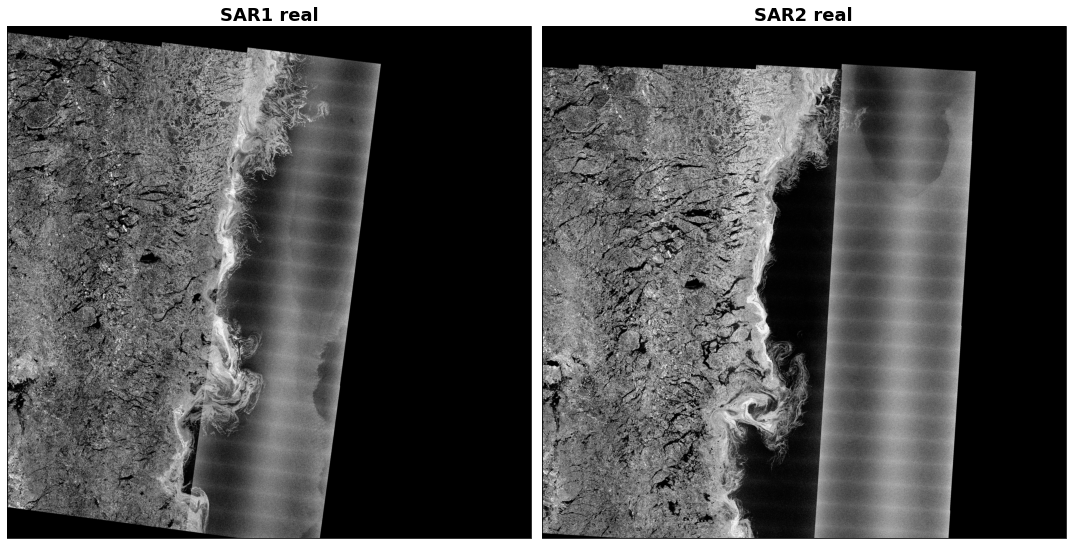

In [160]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8), subplot_kw={'projection': crs})

image1 = ax1.imshow(nansat_sar1_real[1] , cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(nansat_sar2_real[1] , cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('SAR1 real', fontdict={'fontsize': 18, 'fontweight': 'bold'})
ax2.set_title('SAR2 real', fontdict={'fontsize': 18, 'fontweight': 'bold'})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])

plt.tight_layout()
plt.show()


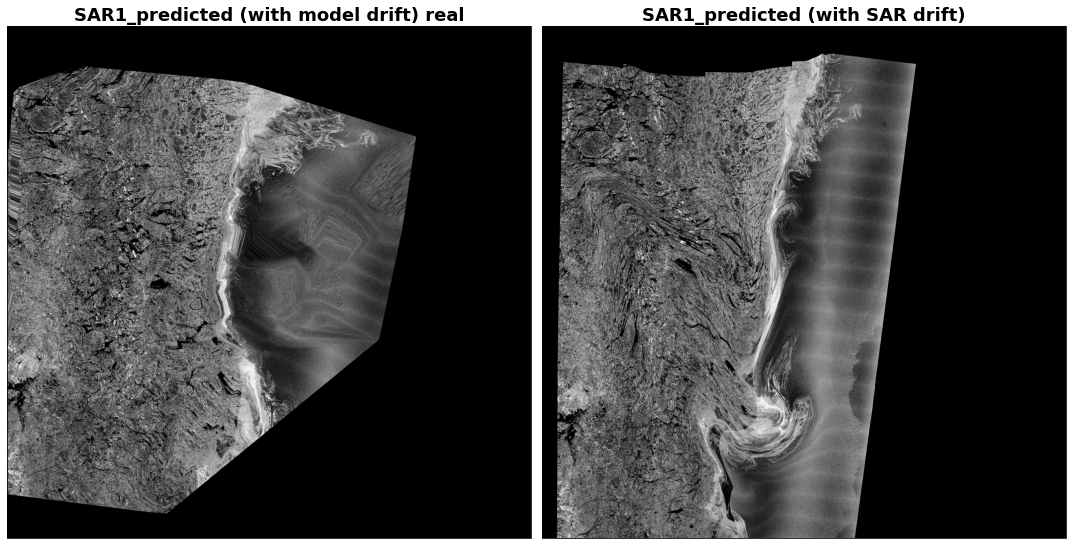

In [159]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8), subplot_kw={'projection': crs})

image1 = ax1.imshow(nansat_sar2_predicted[1] , cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(nansat_sar2_mod_predicted[1] , cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('SAR1_predicted (with model drift) real', fontdict={'fontsize': 18, 'fontweight': 'bold'})
ax2.set_title('SAR1_predicted (with SAR drift)', fontdict={'fontsize': 18, 'fontweight': 'bold'})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])

plt.tight_layout()
plt.show()


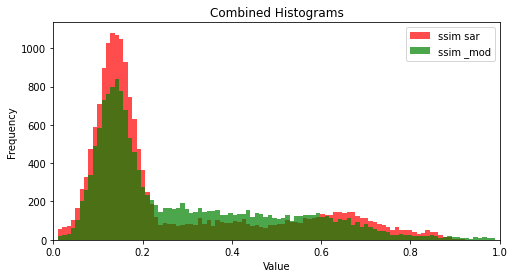

In [161]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(8, 4))

bins = 100

# Create histograms

plt.hist(ssim.flatten(), bins, [0.01, 0.99], alpha=0.7, label='ssim sar', color = 'red')
plt.hist(ssim_mod.flatten(), bins, [0.01, 0.99], alpha=0.7, label='ssim _mod', color = 'green')


# Add a legend
plt.legend(loc='upper right')

plt.xlim(0, 1)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



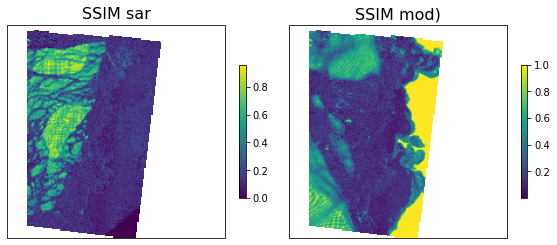

In [157]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4), subplot_kw={'projection': crs})

image1 = ax1.imshow(ssim , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(ssim_mod , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('SSIM sar', fontdict={'fontsize': 16})
ax2.set_title('SSIM mod)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


## Calculation of distortion for SAR1 predicted with SAR drift

Run reverse

In [ ]:
n2[1].shape

(5354, 5253)

In [86]:

n2.shape(), nansat_sar2_real.shape(), nansat_sar2_predicted.shape()

((5354, 5253), (7051, 5451), (7051, 5451))

In [96]:
#Calculate regular grid fro Feature tracking

# Meshgrid Approach
c1, r1 = np.meshgrid(
    np.arange(1, nansat_sar2_real.shape()[1], 250),
    np.arange(1, nansat_sar2_real.shape()[0], 250))
c1, r1 = c1.flatten(), r1.flatten()
lon1ft, lat1ft = nansat_sar2_real.transform_points(c1, r1)
c2, r2 = nansat_sar2_predicted.transform_points(lon1ft, lat1ft, DstToSrc=True)
lon2ft, lat2ft = nansat_sar2_predicted.transform_points(c2, r2)

margin = 200
gpi = ((c1 > margin) * (r1 > margin) * (c1 < (n1.shape()[1]-margin)) * (r1 < (n1.shape()[0]-margin)) *
       (c2 > margin) * (r2 > margin) * (c2 < (n2.shape()[1]-margin)) * (r2 < (n2.shape()[0]-margin)))

c1, r1, c2, r2 = c1[gpi], r1[gpi], c2[gpi], r2[gpi]

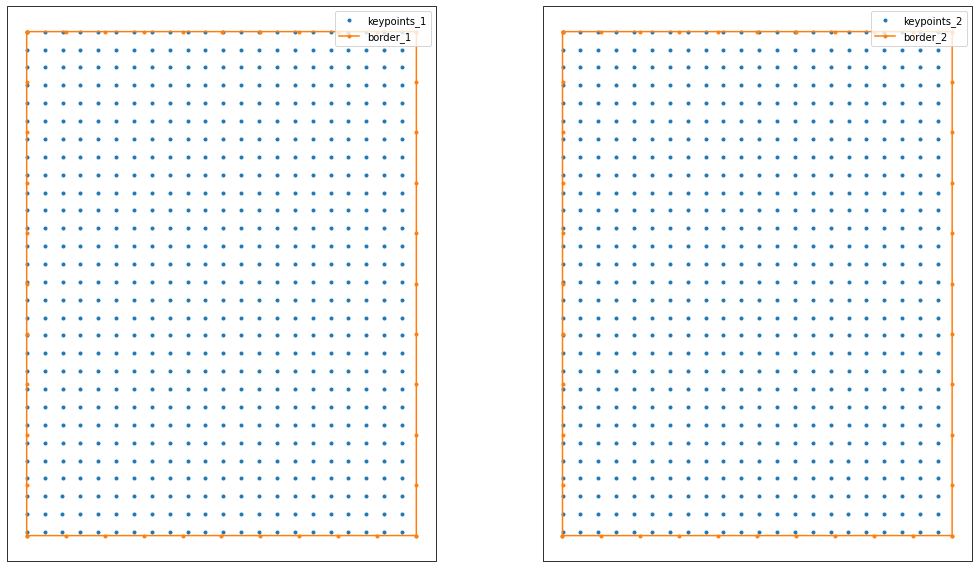

In [109]:
# Plot identified and matched keypoints in geographic coordinates


# get lon/lat coordinates of the border of images
lon1b, lat1b = nansat_sar2_real.get_border()
lon2b, lat2b = nansat_sar2_predicted.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8), subplot_kw={'projection': crs})

#ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
#ax1.add_feature(land_50m, zorder=0, edgecolor='black')
#ax2 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
#ax2.add_feature(land_50m, zorder=0, edgecolor='black')

ax1.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax2.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax1.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax2.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()


In [110]:

upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_predicted, c2, r2, srs=srs, min_border=400,
                                                                   max_border=400,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 04675.0 05375.0 0000nan 0000nan +0nan 0nan 0nan 0nan4
 Pattern matching - OK! (1925 sec)


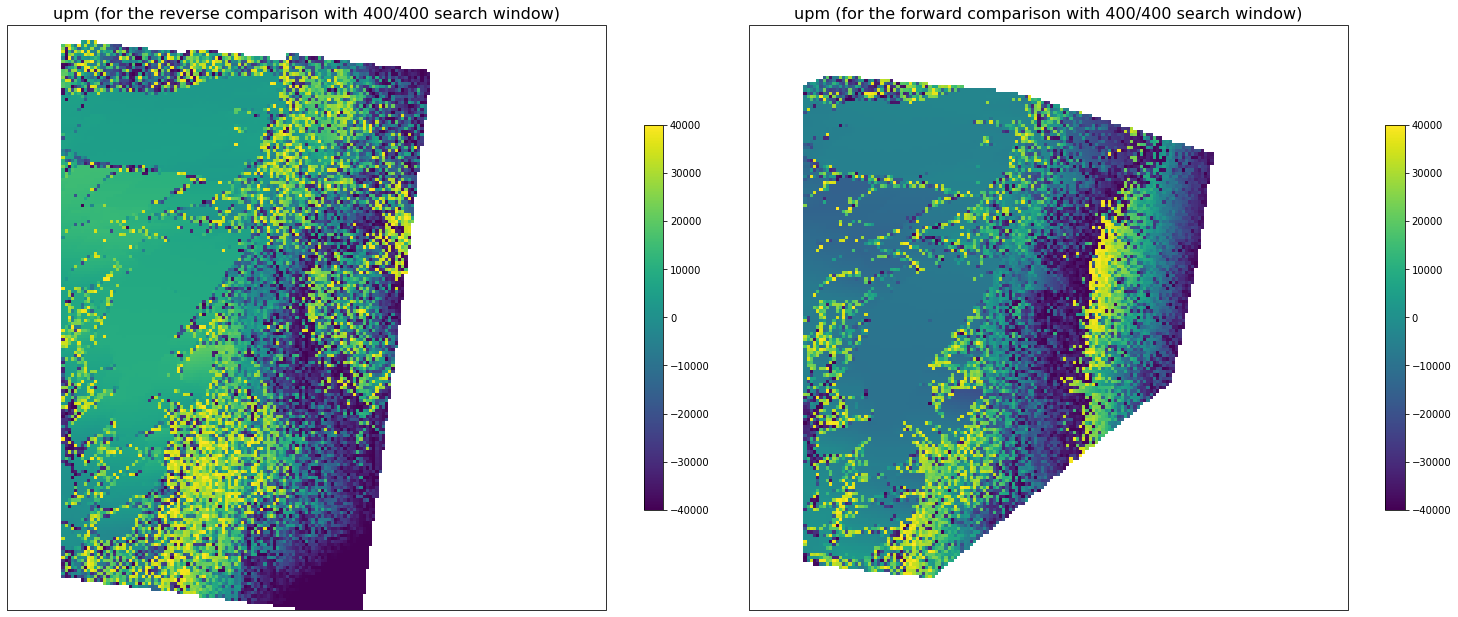

In [122]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(upm , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(upm_for , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('upm (for the reverse comparison with 400/400 search window)', fontdict={'fontsize': 16})
ax2.set_title('upm (for the forward comparison with 400/400 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


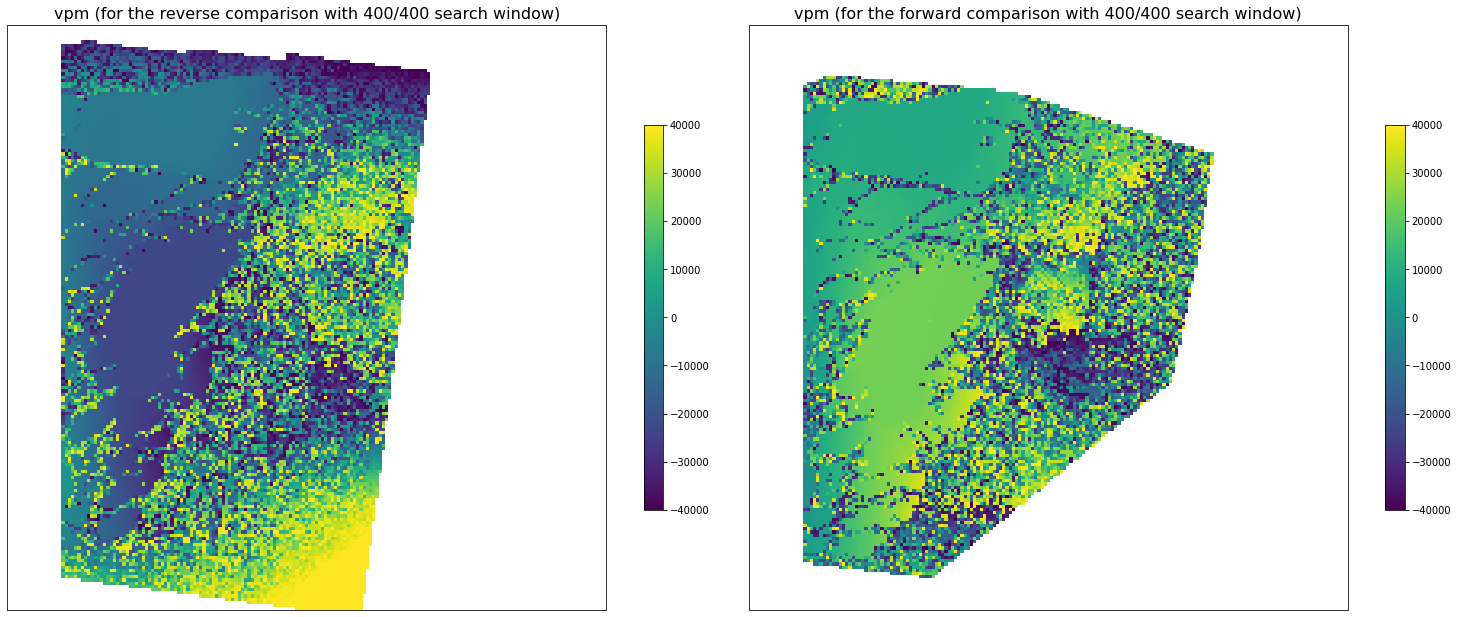

In [123]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(vpm , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(vpm_for , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('vpm (for the reverse comparison with 400/400 search window)', fontdict={'fontsize': 16})
ax2.set_title('vpm (for the forward comparison with 400/400 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


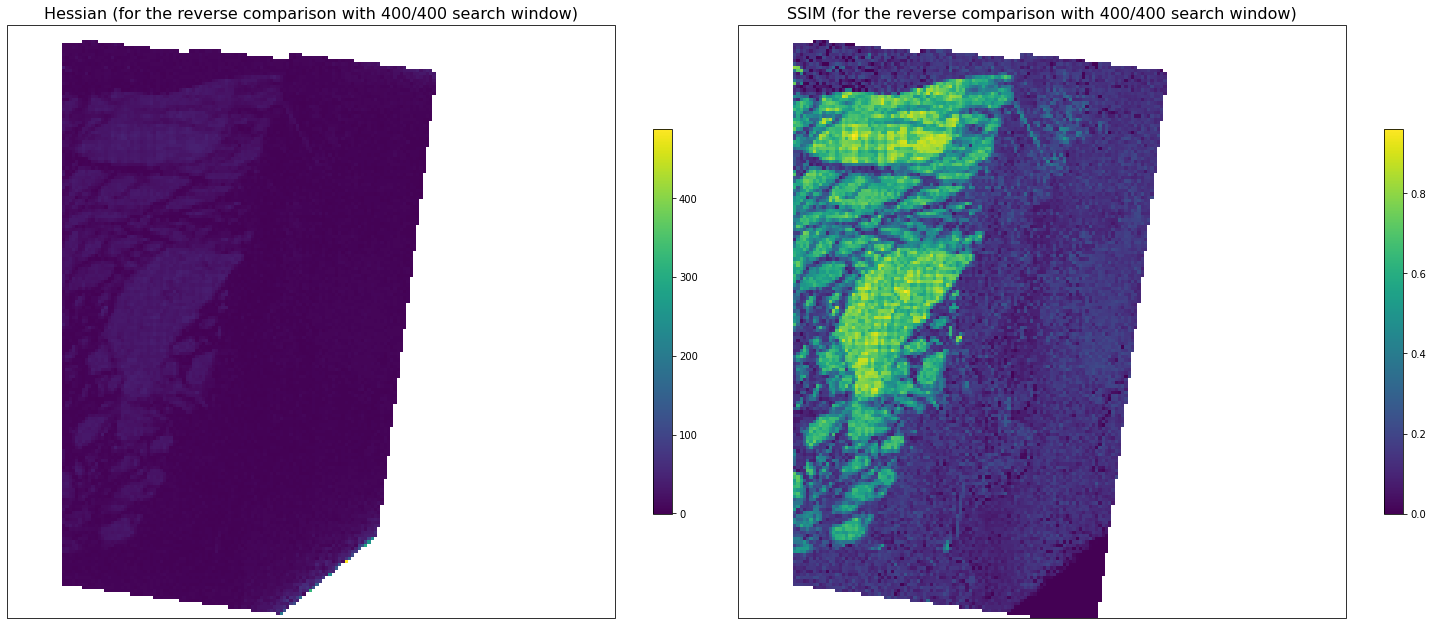

In [124]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(ssim , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('Hessian (for the reverse comparison with 400/400 search window)', fontdict={'fontsize': 16})
ax2.set_title('SSIM (for the reverse comparison with 400/400 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


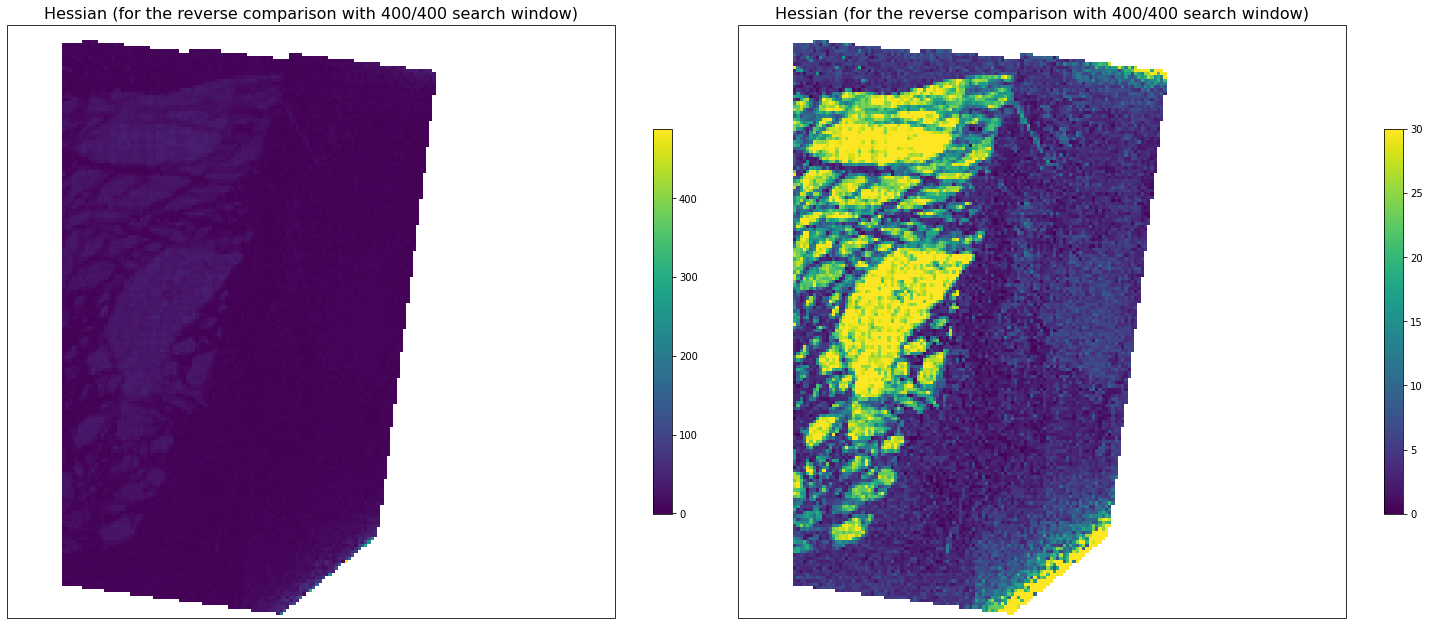

In [125]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(hpm , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30) #nansat_sar2_real[1]
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_title('Hessian (for the reverse comparison with 400/400 search window)', fontdict={'fontsize': 16})
ax2.set_title('Hessian (for the reverse comparison with 400/400 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


In [111]:

upm_200, vpm_200, apm_200, rpm_200, hpm_200, ssim_200, lon2pm_200, lat2pm_200 = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_predicted, c2, r2, srs=srs, min_border=200,
                                                                   max_border=200,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

08% 02225.0 00725.0 0000nan 0000nan +0nan 0nan 0nan 0nan15% 04250.0 01200.0 0000nan 0000nan +0nan 0nan 0nan 0nan05% 02400.0 00550.0 0000nan 0000nan +0nan 0nan 0nan 0nan20% 01400.0 01550.0 0000nan 0000nan +0nan 0nan 0nan 0nan10% 04575.0 00875.0 0000nan 0000nan +0nan 0nan 0nan 0nan05% 02375.0 00575.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 04550.0 00900.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 04875.0 00575.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 05200.0 00250.0 0000nan 0000nan +0nan 0nan 0nan 0nan21% 01350.0 01600.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 04525.0 00925.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 01675.0 01275.0 0000nan 0000nan +0nan 0nan 0nan 0nan21% 03850.0 01600.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 04850.0 00600.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 02000.0 00950.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 04175.0 01275.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 02325.0 00625.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 04500.0 00950.0 0000nan 0000nan +0nan 0nan 0

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 04950.0 05500.0 0000nan 0000nan +0nan 0nan 0nan 0nan3
 Pattern matching - OK! (462 sec)


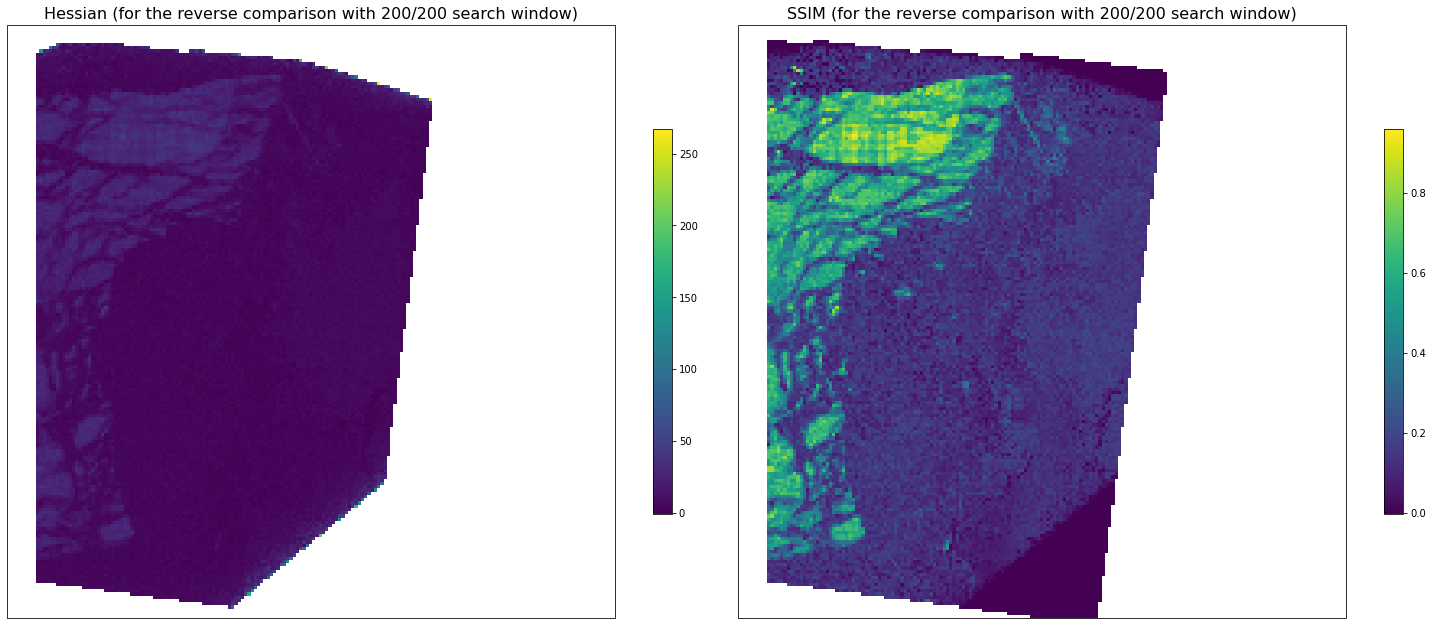

In [126]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(ssim_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('Hessian (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})
ax2.set_title('SSIM (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


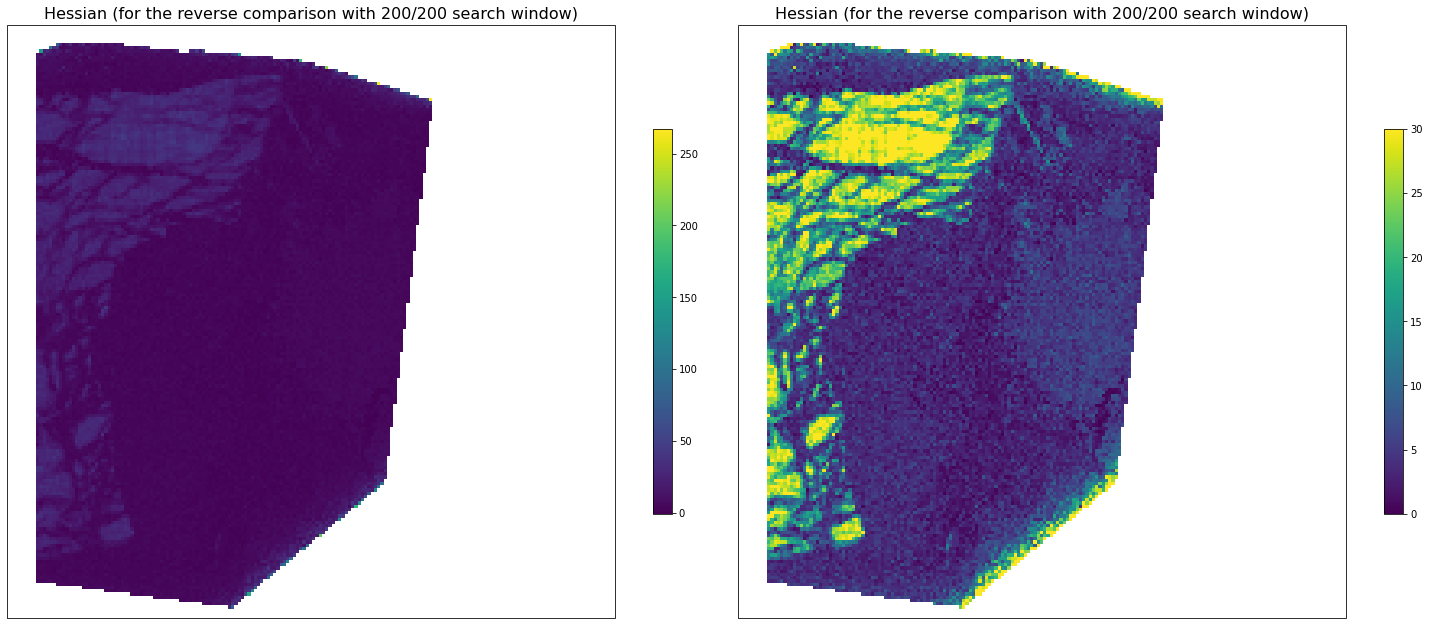

In [127]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(hpm_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30) #nansat_sar2_real[1]
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_title('Hessian (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})
ax2.set_title('Hessian (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


In [112]:

upm_100, vpm_100, apm_100, rpm_100, hpm_100, ssim_100, lon2pm_100, lat2pm_100 = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_predicted, c2, r2, srs=srs, min_border=100,
                                                                   max_border=100,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 01075.0 05575.0 00982.0 05582.0 +20.0 0.36 6.47 0.244
 Pattern matching - OK! (145 sec)


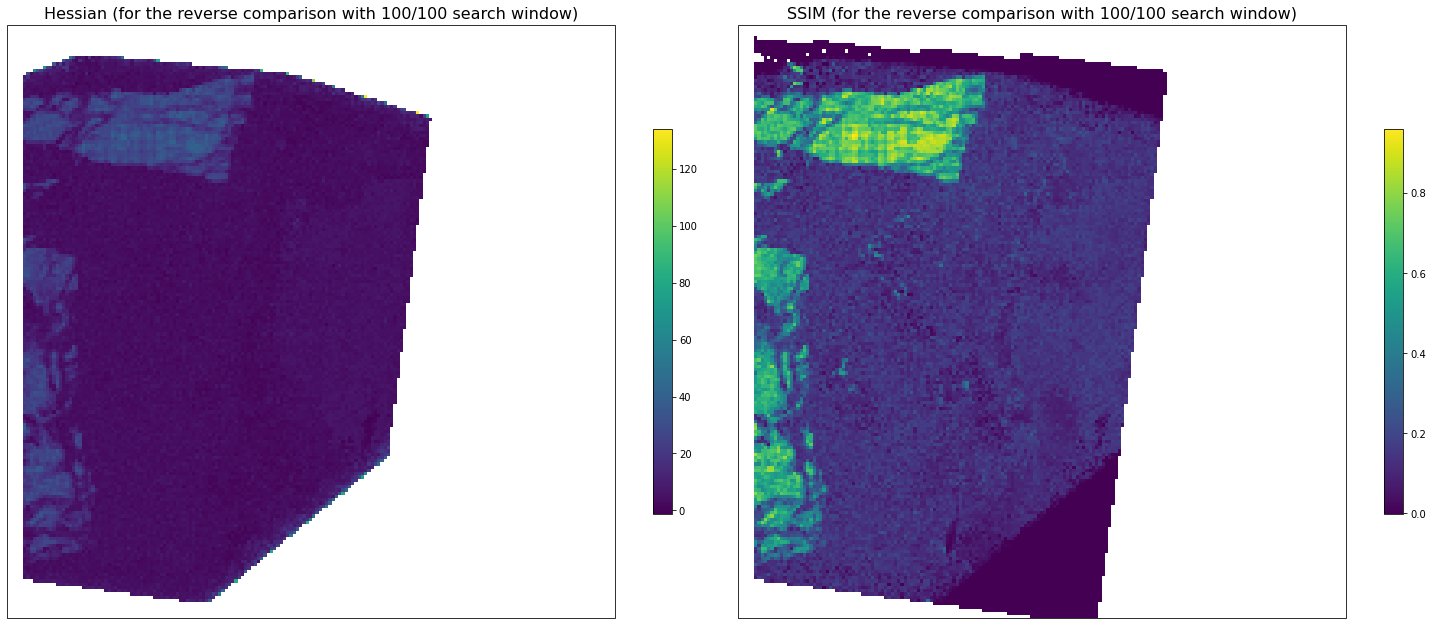

In [128]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_100 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(ssim_100 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('Hessian (for the reverse comparison with 100/100 search window)', fontdict={'fontsize': 16})
ax2.set_title('SSIM (for the reverse comparison with 100/100 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


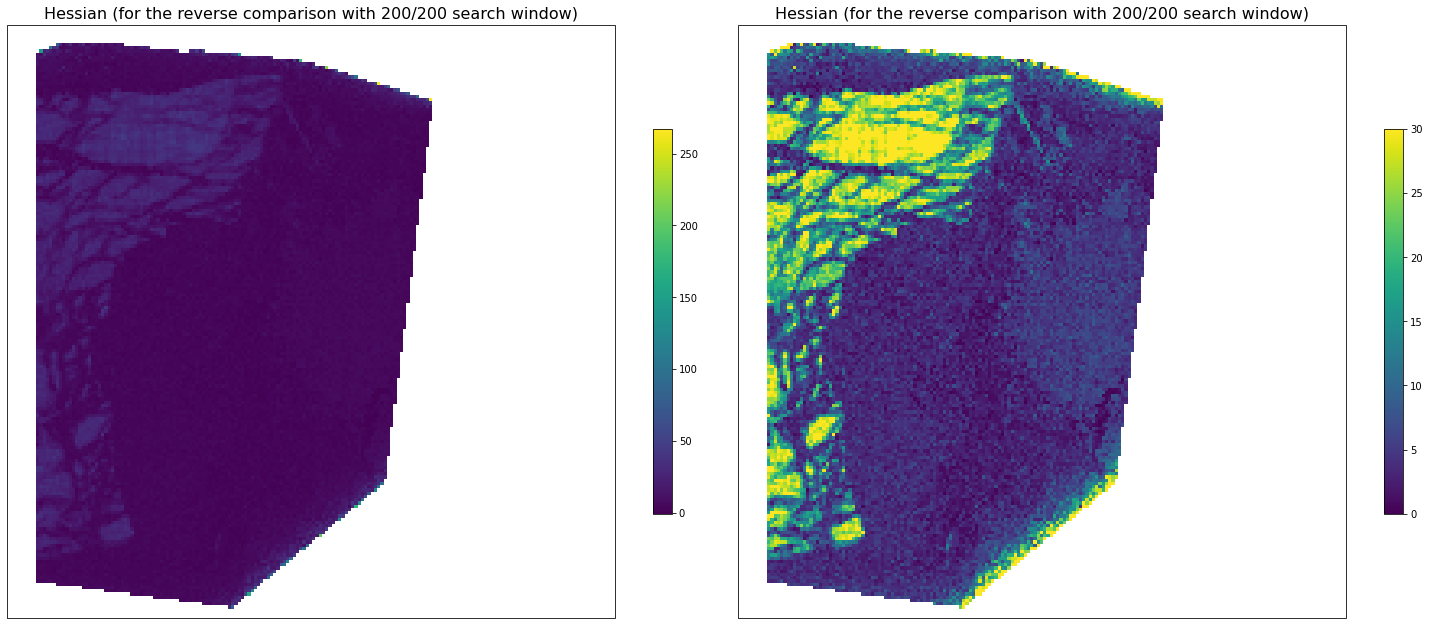

In [132]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(hpm_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30) #nansat_sar2_real[1]
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_title('Hessian (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})
ax2.set_title('Hessian (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


In [113]:

upm_10, vpm_10, apm_10, rpm_10, hpm_10, ssim_10, lon2pm_10, lat2pm_10 = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_predicted, c2, r2, srs=srs, min_border=100,
                                                                   max_border=10,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


40% 03425.0 02825.0 0000nan 0000nan +0nan 0nan 0nan 0nan

/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 04300.0 05600.0 0000nan 0000nan +0nan 0nan 0nan 0nann5% 01300.0 05300.0 01308.0 05303.0 +45.0 0.28 2.76 0.1180% 01050.0 05650.0 01060.0 05642.0 -50.0 0.14 1.48 0.1294% 04675.0 06575.0 0000nan 0000nan +0nan 0nan 0nan 0nan94% 01800.0 06600.0 0000nan 0000nan +0nan 0nan 0nan 0nan75% 04550.0 05250.0 0000nan 0000nan +0nan 0nan 0nan 0nan89% 04550.0 06250.0 0000nan 0000nan +0nan 0nan 0nan 0nan100% 03675.0 06975.0 0000nan 0000nan +0nan 0nan 0nan 0nan89% 01675.0 06275.0 0000nan 0000nan +0nan 0nan 0nan 0nan
 Pattern matching - OK! ( 34 sec)


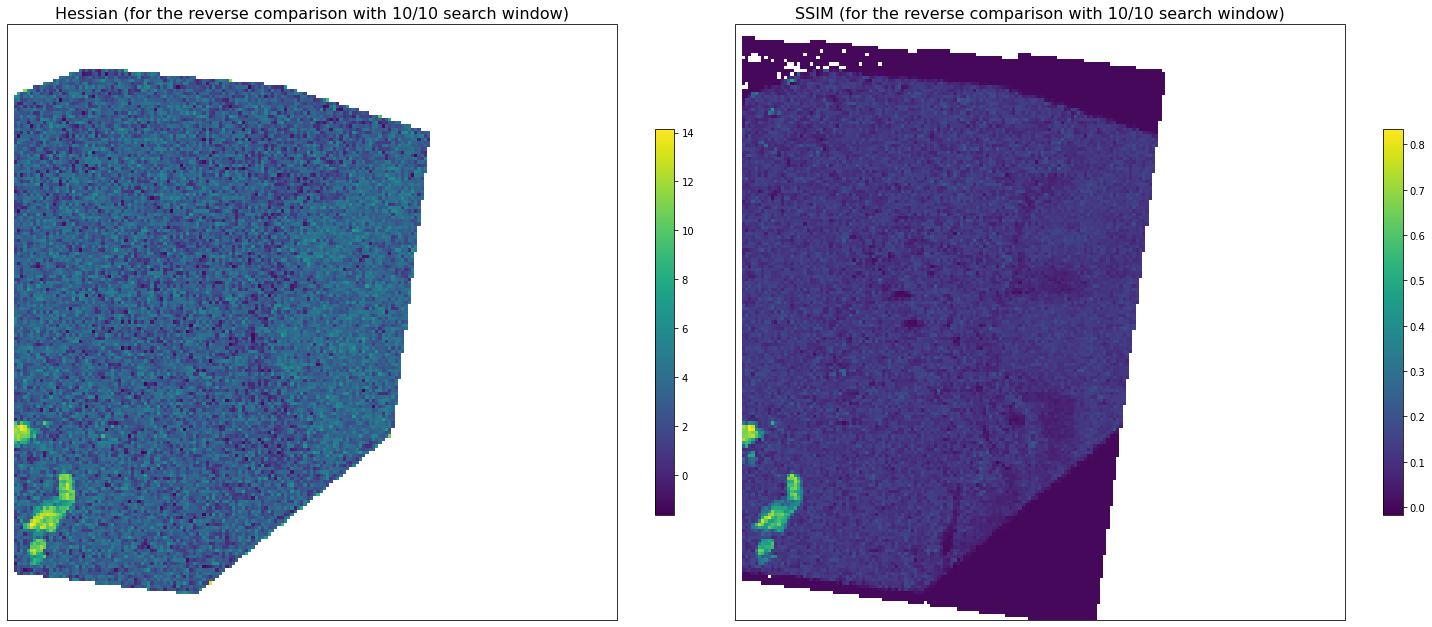

In [130]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_10 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(ssim_10 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('Hessian (for the reverse comparison with 10/10 search window)', fontdict={'fontsize': 16})
ax2.set_title('SSIM (for the reverse comparison with 10/10 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


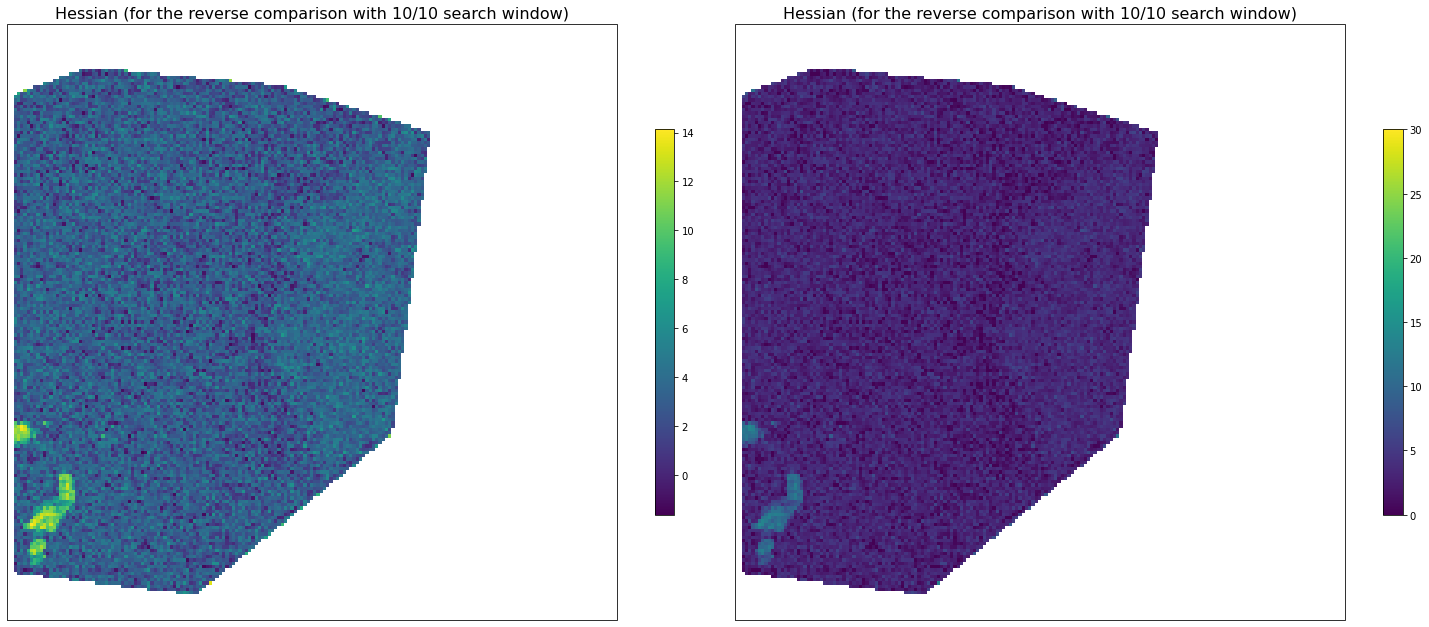

In [131]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_10 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(hpm_10 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30) #nansat_sar2_real[1]
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_title('Hessian (for the reverse comparison with 10/10 search window)', fontdict={'fontsize': 16})
ax2.set_title('Hessian (for the reverse comparison with 10/10 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


Run direct

In [ ]:
# 5.3.1. Run feature tracking and plot results 
#c1_for, r1_for, c2_for, r2_for = feature_tracking(nansat_sar2_predicted,nansat_sar2_real, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)



Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 50000
Domain filter: 50000 -> 50000
Keypoints matched 9.375195980072021
Ratio test 0.600000 found 4999 keypoints
MaxDrift filter: 4999 -> 4999
LSTSQ filter: 4999 -> 4997


In [114]:

upm_for, vpm_for, apm_for, rpm_for, hpm_for, ssim_for, lon2pm_for, lat2pm_for = pattern_matching(lon1pm, lat1pm, nansat_sar2_predicted , c1, r1,  nansat_sar2_real, c2, r2, srs=srs, min_border=400,
                                                                   max_border=400,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

85% 02050.0 05700.0 0000nan 0000nan +0nan 0nan 0nan 0nan05% 04925.0 00725.0 0000nan 0000nan +0nan 0nan 0nan 0nan10% 02300.0 01050.0 0000nan 0000nan +0nan 0nan 0nan 0nan05% 02800.0 00750.0 0000nan 0000nan +0nan 0nan 0nan 0nan20% 04175.0 01675.0 0000nan 0000nan +0nan 0nan 0nan 0nan00% 00800.0 00450.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 02675.0 01075.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 00675.0 00775.0 0000nan 0000nan +0nan 0nan 0nan 0nan21% 02050.0 01700.0 0000nan 0000nan +0nan 0nan 0nan 0nan21% 04550.0 01700.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 03175.0 00775.0 0000nan 0000nan +0nan 0nan 0nan 0nan21% 02425.0 01725.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 00425.0 01425.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 03675.0 00475.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 03550.0 00800.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 00925.0 01125.0 0000nan 0000nan +0nan 0nan 0nan 0nan21% 04925.0 01725.0 0000nan 0000nan +0nan 0nan 0nan 0nan12% 01300.0 01150.0 0000nan 0000nan +0nan 0nan 0

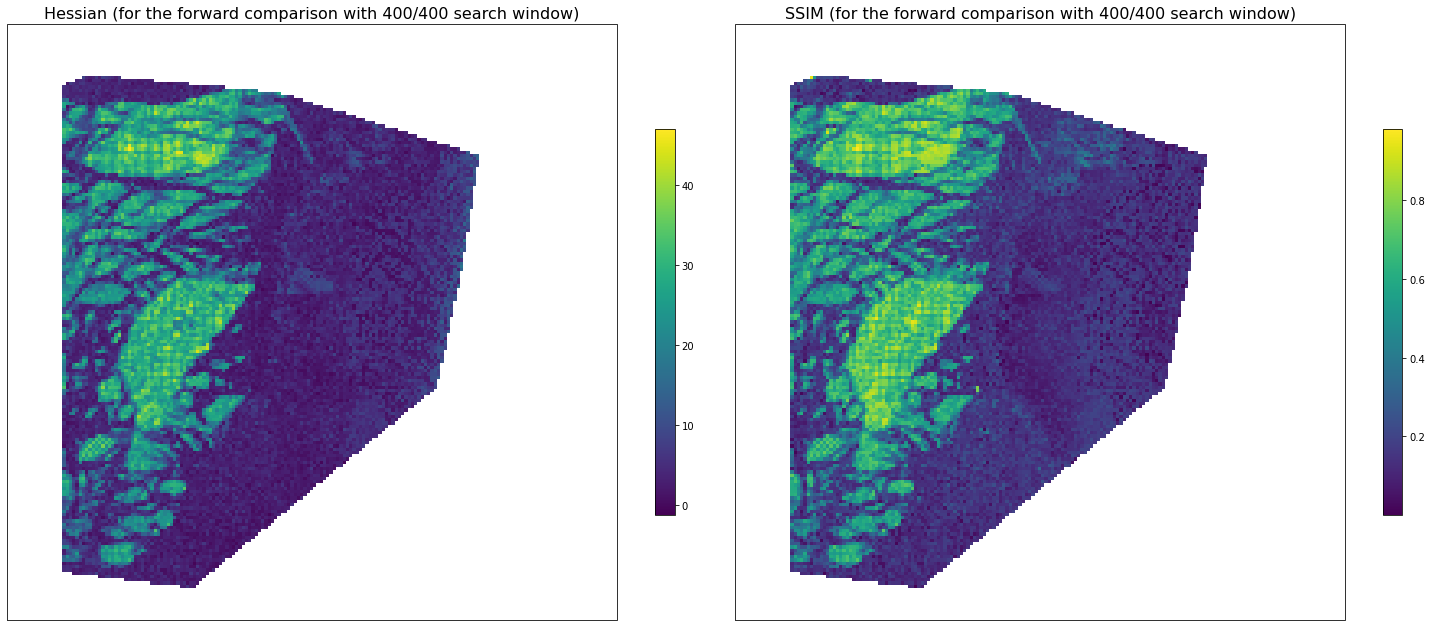

In [133]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_for , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(ssim_for , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('Hessian (for the forward comparison with 400/400 search window)', fontdict={'fontsize': 16})
ax2.set_title('SSIM (for the forward comparison with 400/400 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


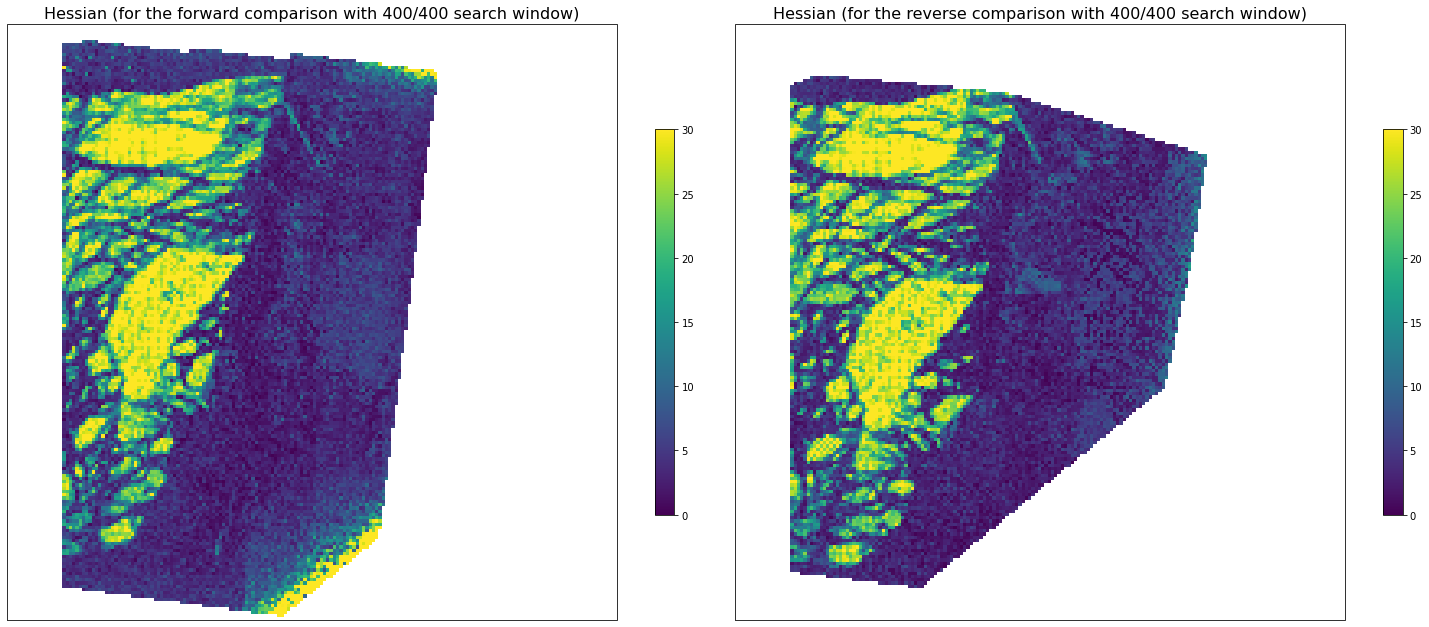

In [134]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Mask the pixels with value 1
#masked_warp_gpi = np.ma.masked_where(warp_gpi == 1, warp_gpi)
#masked_warp_gpi = sar_warped_mask_list[0]
#masked_warp_gpi_plot = np.ma.masked_where(sar_warped_mask_list[0] == 1, sar_warped_mask_list[0])
#sar_gpi2_plot = np.ma.masked_where(gpi2_list[0] == 1, sar_warped_mask_list[0])
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()],  vmin = 0, vmax = 30) #, vmin = 0, vmax = 30
#ax1.imshow(sar_gpi2_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])
image2 = ax2.imshow(hpm_for , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()], vmin = 0, vmax = 30) #nansat_sar2_real[1]
#ax2.imshow(masked_warp_gpi_plot, cmap='gray', extent=[x100.min(), x100.max(), y100.min(), y100.max()])

ax1.set_title('Hessian (for the forward comparison with 400/400 search window)', fontdict={'fontsize': 16})
ax2.set_title('Hessian (for the reverse comparison with 400/400 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


In [115]:

upm_for_200, vpm_for_200, apm_for_200, rpm_for_200, hpm_for_200, ssim_for_200, lon2pm_for_200, lat2pm_for_200 = pattern_matching(lon1pm, lat1pm, nansat_sar2_predicted , c1, r1,  nansat_sar2_real, c2, r2, srs=srs, min_border=400,
                                                                   max_border=200,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 04950.0 05500.0 0000nan 0000nan +0nan 0nan 0nan 0nann
 Pattern matching - OK! (413 sec)


In [54]:

upm_for_100, vpm_for_100, apm_for_100, rpm_for_100, hpm_for_100, ssim_for_100, lon2pm_for_100, lat2pm_for_100 = pattern_matching(lon1pm, lat1pm, nansat_sar2_predicted , c1, r1,  nansat_sar2_real, c2, r2, srs=srs, min_border=400,
                                                                   max_border=100,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 02025.0 05600.0 0000nan 0000nan +0nan 0nan 0nan 0nann2% 03625.0 03700.0 0000nan 0000nan +0nan 0nan 0nan 0nan55% 00100.0 03950.0 00995.0 03916.0 +09.0 0.30 4.86 0.1987% 01975.0 06075.0 0000nan 0000nan +0nan 0nan 0nan 0nan87% 00275.0 06100.0 0000nan 0000nan +0nan 0nan 0nan 0nan
 Pattern matching - OK! (126 sec)


In [116]:

upm_for_10, vpm_for_10, apm_for_10, rpm_for_10, hpm_for_10, ssim_for_10, lon2pm_for_10, lat2pm_for_10 = pattern_matching(lon1pm, lat1pm, nansat_sar2_predicted , c1, r1,  nansat_sar2_real, c2, r2, srs=srs, min_border=400,
                                                                   max_border=10,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

26% 00925.0 01825.0 0000nan 0000nan +0nan 0nan 0nan 0nan00% 00050.0 00050.0 0000nan 0000nan +0nan 0nan 0nan 0nan10% 04925.0 00725.0 0000nan 0000nan +0nan 0nan 0nan 0nan15% 04675.0 01075.0 0000nan 0000nan +0nan 0nan 0nan 0nan20% 04425.0 01425.0 0000nan 0000nan +0nan 0nan 0nan 0nan00% 02550.0 00050.0 0000nan 0000nan +0nan 0nan 0nan 0nan15% 01800.0 01100.0 0000nan 0000nan +0nan 0nan 0nan 0nan00% 05050.0 00050.0 0000nan 0000nan +0nan 0nan 0nan 0nan20% 04050.0 01450.0 0000nan 0000nan +0nan 0nan 0nan 0nan15% 04300.0 01100.0 0000nan 0000nan +0nan 0nan 0nan 0nan05% 04800.0 00400.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 01925.0 00425.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 04175.0 00775.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 01300.0 00800.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 01800.0 00100.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 01550.0 00450.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 03550.0 01150.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 00925.0 00825.0 0000nan 0000nan +0nan 0nan 0

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


65% 05050.0 04550.0 0000nan 0000nan +0nan 0nan 0nan 0nann60% 02800.0 04200.0 02799.0 04194.0 +50.0 0.12 4.94 0.1479% 00050.0 05550.0 00044.0 05544.0 +00.0 0.15 3.08 0.1190% 00925.0 06325.0 0000nan 0000nan +0nan 0nan 0nan 0nan86% 03300.0 06000.0 0000nan 0000nan +0nan 0nan 0nan 0nan90% 03425.0 06325.0 0000nan 0000nan +0nan 0nan 0nan 0nan86% 00425.0 06025.0 0000nan 0000nan +0nan 0nan 0nan 0nan90% 00550.0 06350.0 0000nan 0000nan +0nan 0nan 0nan 0nan86% 02925.0 06025.0 0000nan 0000nan +0nan 0nan 0nan 0nan91% 02300.0 06400.0 0000nan 0000nan +0nan 0nan 0nan 0nan87% 04675.0 06075.0 0000nan 0000nan +0nan 0nan 0nan 0nan88% 01050.0 06150.0 0000nan 0000nan +0nan 0nan 0nan 0nan88% 03550.0 06150.0 0000nan 0000nan +0nan 0nan 0nan 0nan88% 00300.0 06200.0 0000nan 0000nan +0nan 0nan 0nan 0nan88% 02800.0 06200.0 0000nan 0000nan +0nan 0nan 0nan 0nan93% 00425.0 06525.0 0000nan 0000nan +0nan 0nan 0nan 0nan89% 05300.0 06200.0 0000nan 0000nan +0nan 0nan 0nan 0nan93% 00050.0 06550.0 0000nan 0000nan +0nan 0nan 

## Calculation of distortion for SAR1 predicted with model drift

Reverse run

In [117]:
# 5.3.1. Run feature tracking and plot results 
#c1_mod, r1_mod, c2_mod, r2_mod = feature_tracking(nansat_sar2_real, nansat_sar2_mod_predicted, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)


upm_mod, vpm_mod, apm_mod, rpm_mod, hpm_mod, ssim_mod, lon2pm_mod, lat2pm_mod = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_mod_predicted, c2, r2, srs=srs, min_border=400,
                                                                   max_border=400,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

85% 02050.0 05700.0 01694.0 05578.0 +20.0 0.23 1.57 0.1100% 02300.0 01050.0 0000nan 0000nan +0nan 0nan 0nan 0nan15% 04300.0 01350.0 0000nan 0000nan +0nan 0nan 0nan 0nan00% 00800.0 00450.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 04675.0 01375.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 02675.0 01075.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 00675.0 00775.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 00550.0 01100.0 0000nan 0000nan +0nan 0nan 0nan 0nan06% 03175.0 00775.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 00925.0 01125.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 03675.0 00475.0 0000nan 0000nan +0nan 0nan 0nan 0nan12% 03425.0 01125.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 01550.0 00500.0 0000nan 0000nan +0nan 0nan 0nan 0nan07% 03925.0 00825.0 0000nan 0000nan +0nan 0nan 0nan 0nan02% 01925.0 00525.0 0000nan 0000nan +0nan 0nan 0nan 0nan13% 04550.0 01200.0 0000nan 0000nan +0nan 0nan 0nan 0nan03% 02675.0 00575.0 0000nan 0000nan +0nan 0nan 0nan 0nan08% 02925.0 00925.0 0000nan 0000nan +0nan 0nan 0

In [118]:
# 5.3.1. Run feature tracking and plot results 
#c1_mod, r1_mod, c2_mod, r2_mod = feature_tracking(nansat_sar2_real, nansat_sar2_mod_predicted, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)


upm_mod_200, vpm_mod_200, apm_mod_200, rpm_mod_200, hpm_mod_200, ssim_mod_200, lon2pm_mod_200, lat2pm_mod_200 = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_mod_predicted, c2, r2, srs=srs, min_border=400,
                                                                   max_border=200,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 04950.0 05500.0 0000nan 0000nan +0nan 0nan 0nan 0nan185% 02100.0 05850.0 02052.0 06050.0 +35.0 0.23 0.70 0.1098% 03775.0 06675.0 0000nan 0000nan +0nan 0nan 0nan 0nan
 Pattern matching - OK! (525 sec)


In [119]:
c1_mod, r1_mod, c2_mod, r2_mod = feature_tracking(nansat_sar2_real, nansat_sar2_mod_predicted, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

upm_mod_100, vpm_mod_100, apm_mod_100, rpm_mod_100, hpm_mod_100, ssim_mod_100, lon2pm_mod_100, lat2pm_mod_100 = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_mod_predicted, c2, r2, srs=srs, min_border=400,
                                                                   max_border=100,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 50000
Domain filter: 50000 -> 50000
Keypoints matched 6.014245986938477
Ratio test 0.600000 found 4637 keypoints
MaxDrift filter: 4637 -> 4636
LSTSQ filter: 4636 -> 4445
07% 00850.0 00600.0 0000nan 0000nan +0nan 0nan 0nan 0nan05% 04700.0 00450.0 0000nan 0000nan +0nan 0nan 0nan 0nan20% 00250.0 01500.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 02400.0 00150.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 03175.0 01175.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 04900.0 00150.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 00450.0 01200.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 03600.0 00850.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 02175.0 00175.0 0000nan 0000nan +0nan 0nan 0nan 0nan21% 05025.0 01525.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 02950.0 01200.0 0000nan 0000nan +0nan 0nan 0nan 0nan11% 00875.0 00875.0 0000nan 0000nan +0nan 0nan 0nan 0nan01% 04675.0 00175.0 0000nan 0000nan +0nan 0nan 0nan 0nan16% 00225.0 01225.0 0000nan 00

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


80% 01075.0 05575.0 01135.0 05519.0 +06.0 0.41 4.19 0.20769% 00550.0 04800.0 00515.0 04792.0 +25.0 0.28 2.33 0.1254% 02275.0 03775.0 02281.0 03769.0 -20.0 0.19 7.06 0.19
 Pattern matching - OK! (162 sec)


In [120]:
upm_mod_10, vpm_mod_10, apm_mod_10, rpm_mod_10, hpm_mod_10, ssim_mod_10, lon2pm_mod_10, lat2pm_mod_10 = pattern_matching(lon1pm, lat1pm, nansat_sar2_real, c1, r1, nansat_sar2_mod_predicted, c2, r2, srs=srs, min_border=400,
                                                                   max_border=10,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


80% 04300.0 05600.0 0000nan 0000nan +0nan 0nan 0nan 0nan039% 01675.0 02775.0 01666.0 02777.0 +40.0 0.26 2.36 0.0829% 02175.0 02075.0 02165.0 02075.0 +35.0 0.15 3.19 0.0952% 03550.0 03650.0 0000nan 0000nan +0nan 0nan 0nan 0nan57% 03300.0 04000.0 0000nan 0000nan +0nan 0nan 0nan 0nan64% 01175.0 04475.0 01172.0 04465.0 +45.0 0.06 1.25 0.1069% 00925.0 04825.0 00917.0 04819.0 +35.0 0.18 3.72 0.1292% 01550.0 06450.0 0000nan 0000nan +0nan 0nan 0nan 0nan92% 04050.0 06450.0 0000nan 0000nan +0nan 0nan 0nan 0nan85% 00800.0 06000.0 0000nan 0000nan +0nan 0nan 0nan 0nan92% 01175.0 06475.0 0000nan 0000nan +0nan 0nan 0nan 0nan75% 01300.0 05300.0 01293.0 05307.0 -45.0 0.25 2.21 0.0895% 03925.0 06625.0 0000nan 0000nan +0nan 0nan 0nan 0nan87% 01425.0 06125.0 0000nan 0000nan +0nan 0nan 0nan 0nan87% 03925.0 06125.0 0000nan 0000nan +0nan 0nan 0nan 0nan83% 03800.0 05800.0 0000nan 0000nan +0nan 0nan 0nan 0nan83% 00925.0 05825.0 00917.0 05825.0 +03.0 0.17 3.13 0.1285% 04050.0 05950.0 0000nan 0000nan +0nan 0nan 

Direct run

In [26]:
# 5.3.1. Run feature tracking and plot results 
#c1_mod_for_400, r1_mod_for_400, c2_mod_for_400, r2_mod_for_400 = feature_tracking(nansat_sar2_mod_predicted, nansat_sar2_real, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 50000
Domain filter: 50000 -> 50000
Keypoints matched 5.462026596069336
Ratio test 0.600000 found 4691 keypoints
MaxDrift filter: 4691 -> 4691
LSTSQ filter: 4691 -> 4492


In [121]:
upm_mod_for_400, vpm_mod_for_400, apm_mod_for_400, rpm_mod_for_400, hpm_mod_for_400, ssim_mod_for_400, lon2pm_mod_for_400, lat2pm_mod_for_400 = pattern_matching(lon1pm, lat1pm, nansat_sar2_mod_predicted, c1, r1, nansat_sar2_real , c2, r2, srs=srs, min_border=400,
                                                                   max_border=400,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

Process ForkPoolWorker-173:
Process ForkPoolWorker-172:
Process ForkPoolWorker-174:
Process ForkPoolWorker-171:
Process ForkPoolWorker-175:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py

96% 02550.0 06400.0 0000nan 0000nan +0nan 0nan 0nan 0nan

KeyboardInterrupt: 

In [ ]:
upm_mod_for_200, vpm_mod_for_200, apm_mod_for_200, rpm_mod_for_200, hpm_mod_for_200, ssim_mod_for_200, lon2pm_mod_for_200, lat2pm_mod_for_200 = pattern_matching(lon1pm, lat1pm, nansat_sar2_mod_predicted, c1, r1, nansat_sar2_real, c2, r2, srs=srs, min_border=400,
                                                                   max_border=200,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

In [ ]:
upm_mod_for_100, vpm_mod_for_100, apm_mod_for_100, rpm_mod_for_100, hpm_mod_for_100, ssim_mod_for_100, lon2pm_mod_for_100, lat2pm_mod_for_100 = pattern_matching(lon1pm, lat1pm, nansat_sar2_mod_predicted, c1, r1, nansat_sar2_real , c2, r2, srs=srs, min_border=400,
                                                                   max_border=100,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

In [ ]:
upm_mod_for_10, vpm_mod_for_10, apm_mod_for_10, rpm_mod_for_10, hpm_mod_for_10, ssim_mod_for_10, lon2pm_mod_for_10, lat2pm_mod_for_10 = pattern_matching(lon1pm, lat1pm, nansat_sar2_mod_predicted, c1, r1, nansat_sar2_real , c2, r2, srs=srs, min_border=400,
                                                                   max_border=10,
                                                                   angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

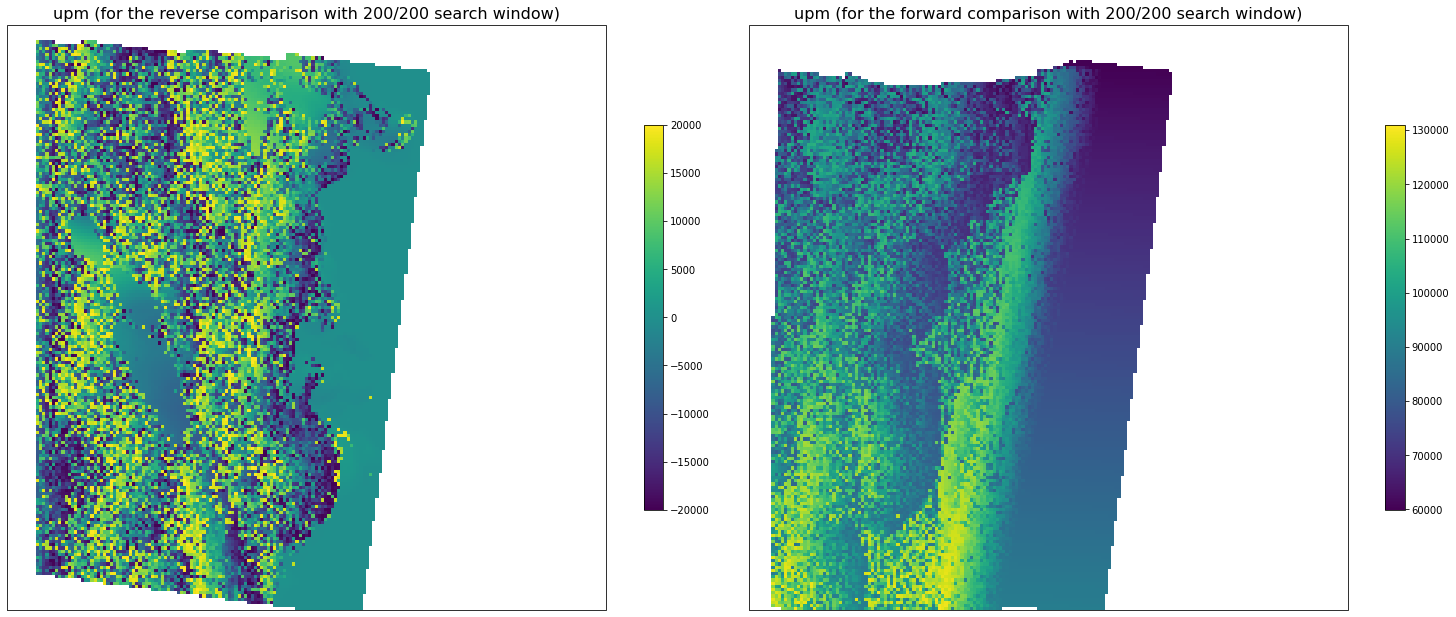

In [135]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(upm_mod_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(upm_mod_for_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('upm (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})
ax2.set_title('upm (for the forward comparison with 200/200 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


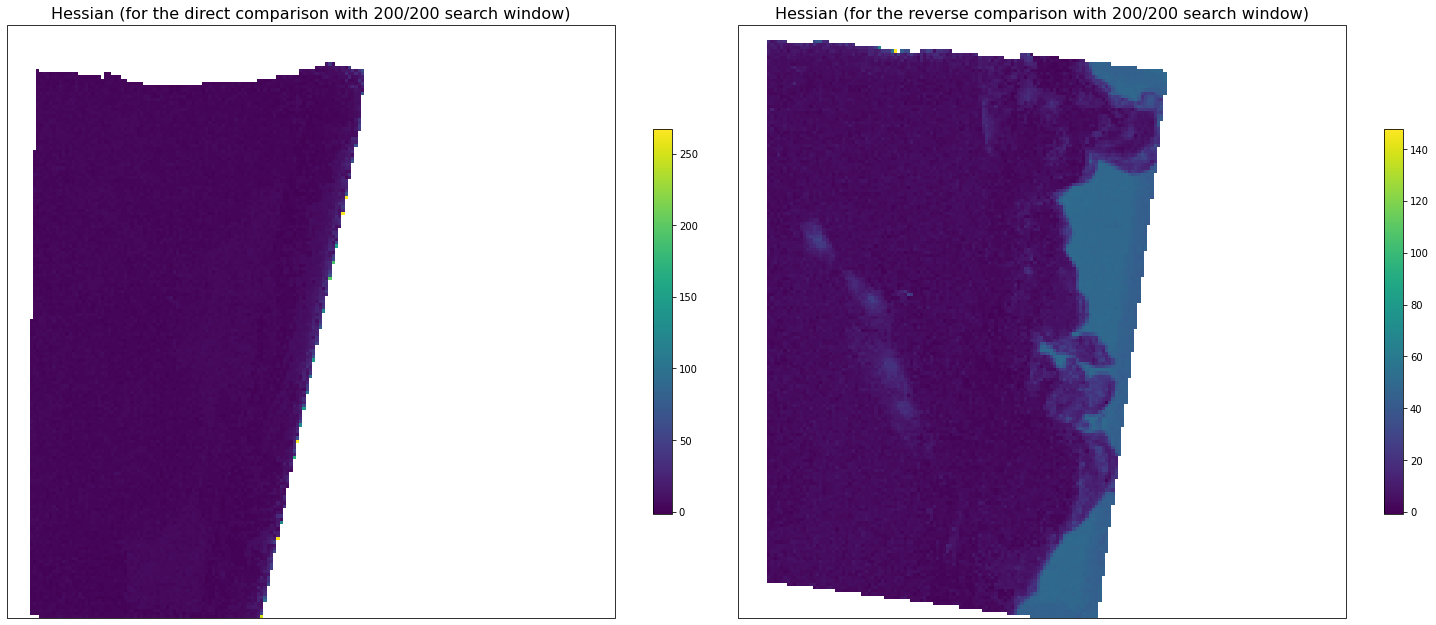

In [136]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(hpm_mod_for_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(hpm_mod_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('Hessian (for the direct comparison with 200/200 search window)', fontdict={'fontsize': 16})
ax2.set_title('Hessian (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


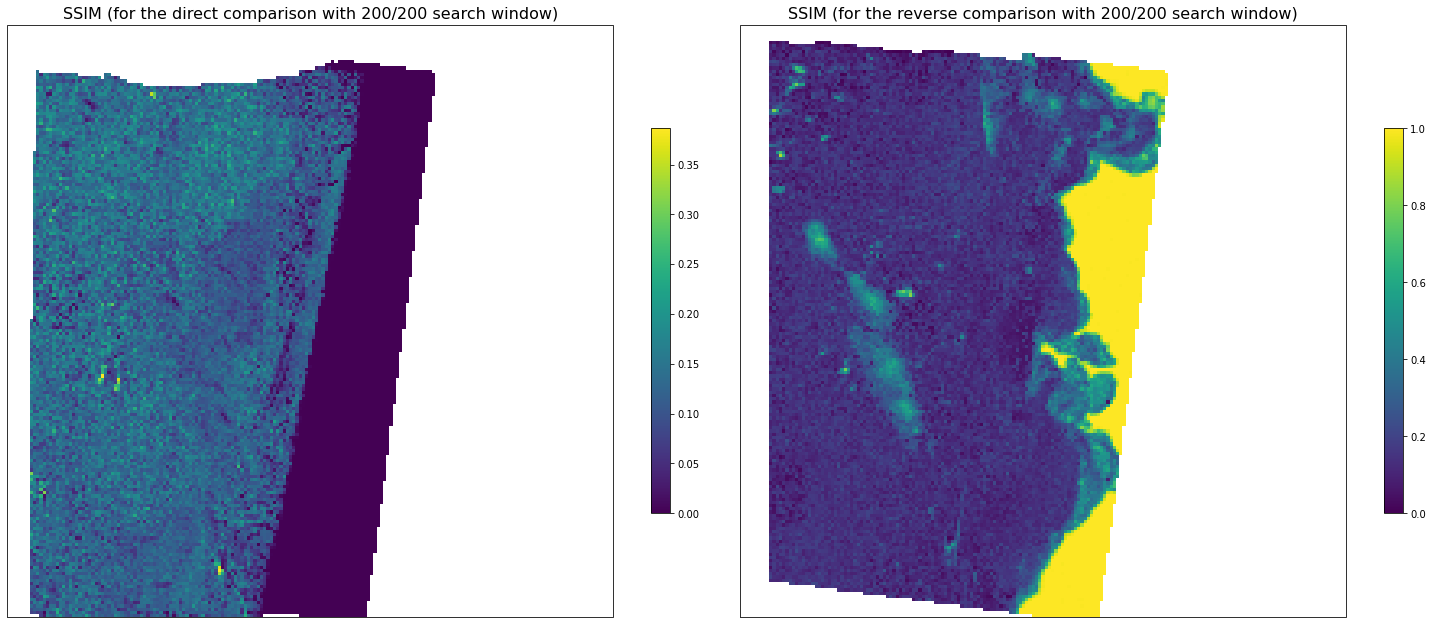

In [137]:
# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21,11), subplot_kw={'projection': crs})

image1 = ax1.imshow(ssim_mod_for_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #, vmin = 0, vmax = 30
image2 = ax2.imshow(ssim_mod_200 , cmap='viridis', extent=[x100.min(), x100.max(), y100.min(), y100.max()]) #nansat_sar2_real[1]

ax1.set_title('SSIM (for the direct comparison with 200/200 search window)', fontdict={'fontsize': 16})
ax2.set_title('SSIM (for the reverse comparison with 200/200 search window)', fontdict={'fontsize': 16})

ax1.set_xlim([x.min(), x.max()-79000])
ax1.set_ylim([y.min()+100000, y.max()-150000])
ax2.set_xlim([x.min(), x.max()-79000])
ax2.set_ylim([y.min()+100000, y.max()-150000])
plt.colorbar(image1, ax=ax1, shrink=0.5)
plt.colorbar(image2, ax=ax2, shrink=0.5)
plt.tight_layout()
plt.show()


## Histograms

sar forecast

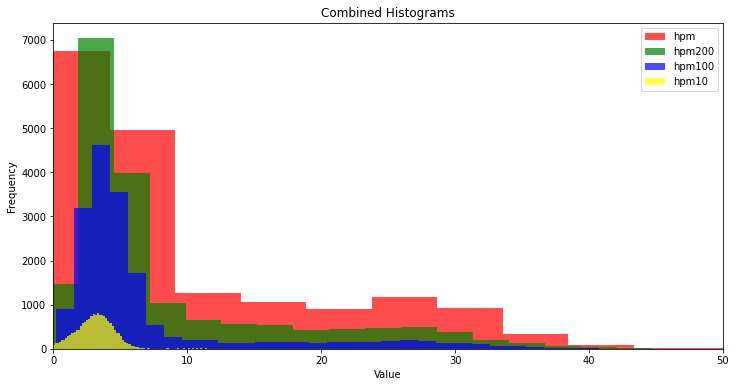

In [140]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms

plt.hist(hpm.flatten(), bins, alpha=0.7, label='hpm', color = 'red')
plt.hist(hpm_200.flatten(), bins, alpha=0.7, label='hpm200', color = 'green')
plt.hist(hpm_100.flatten(), bins, alpha=0.7, label='hpm100', color = 'blue')
plt.hist(hpm_10.flatten(), bins, alpha=0.7, label='hpm10', color = 'yellow')

# Add a legend
plt.legend(loc='upper right')

plt.xlim(0, 50)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



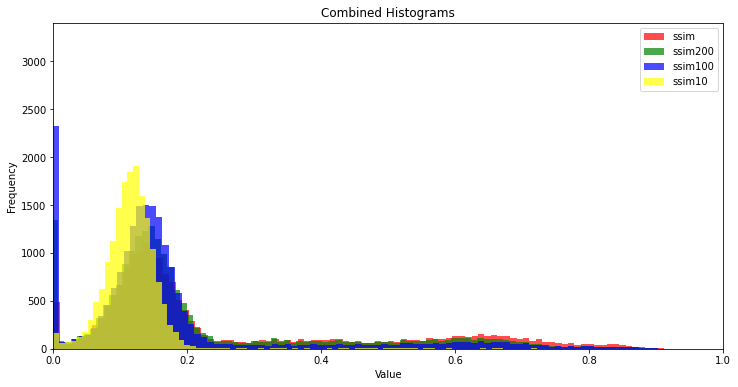

In [141]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms

plt.hist(ssim.flatten(), bins, alpha=0.7, label='ssim', color = 'red')
plt.hist(ssim_200.flatten(), bins, alpha=0.7, label='ssim200', color = 'green')
plt.hist(ssim_100.flatten(), bins, alpha=0.7, label='ssim100', color = 'blue')
plt.hist(ssim_10.flatten(), bins, alpha=0.7, label='ssim10', color = 'yellow')

# Add a legend
plt.legend(loc='upper right')

plt.xlim(0, 1)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



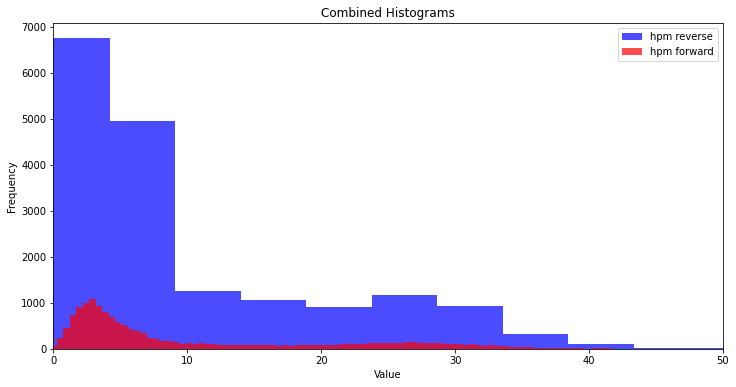

In [142]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms
plt.hist(hpm.flatten(), bins, alpha=0.7, label='hpm reverse', color = 'blue')
plt.hist(hpm_for.flatten(), bins, alpha=0.7, label='hpm forward', color = 'red')


# Add a legend
plt.legend(loc='upper right')

plt.xlim(0, 50)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



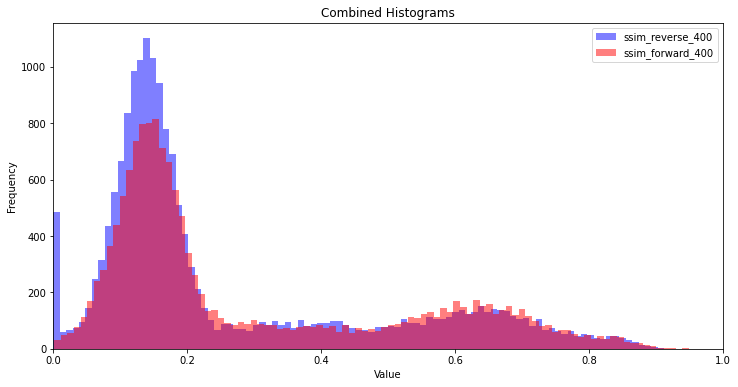

In [143]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms

plt.hist(ssim.flatten(), bins, alpha=0.5, label='ssim_reverse_400', color = 'blue')
plt.hist(ssim_for.flatten(), bins, alpha=0.5, label='ssim_forward_400', color = 'red')


# Add a legend
plt.legend(loc='upper right')

plt.xlim(0, 1)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



model forecast

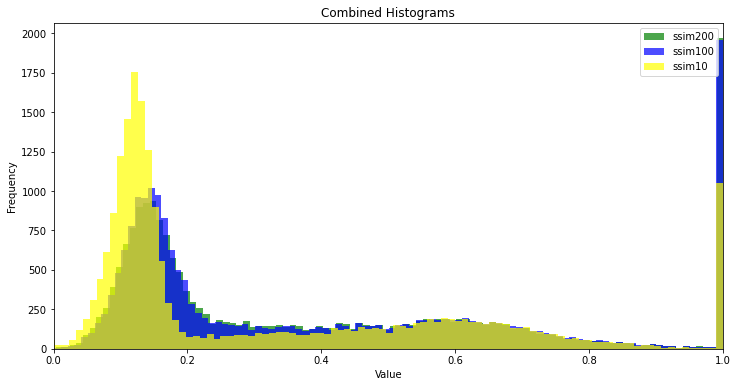

In [37]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms

#plt.hist(ssim_mod_400.flatten(), bins, alpha=0.7, label='ssim', color = 'red')
plt.hist(ssim_mod_200.flatten(), bins, alpha=0.7, label='ssim200', color = 'green')
plt.hist(ssim_mod_100.flatten(), bins, alpha=0.7, label='ssim100', color = 'blue')
plt.hist(ssim_mod_10.flatten(), bins, alpha=0.7, label='ssim10', color = 'yellow')

# Add a legend
plt.legend(loc='upper right')

plt.xlim(0, 1)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



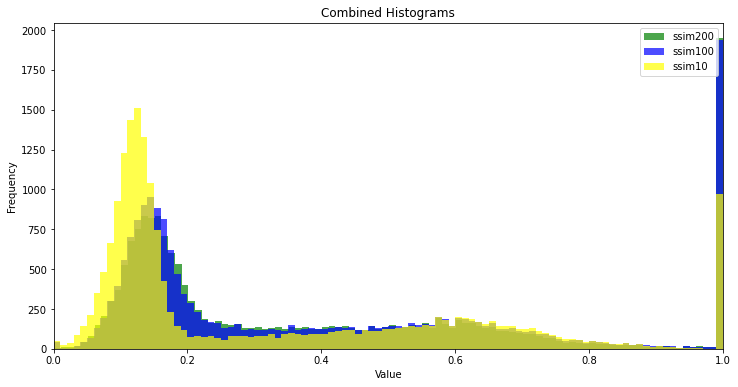

In [38]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms

#plt.hist(ssim_mod_400.flatten(), bins, alpha=0.7, label='ssim', color = 'red')
plt.hist(ssim_mod_for_200.flatten(), bins, alpha=0.7, label='ssim200', color = 'green')
plt.hist(ssim_mod_for_100.flatten(), bins, alpha=0.7, label='ssim100', color = 'blue')
plt.hist(ssim_mod_for_10.flatten(), bins, alpha=0.7, label='ssim10', color = 'yellow')

# Add a legend
plt.legend(loc='upper right')

plt.xlim(0, 1)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



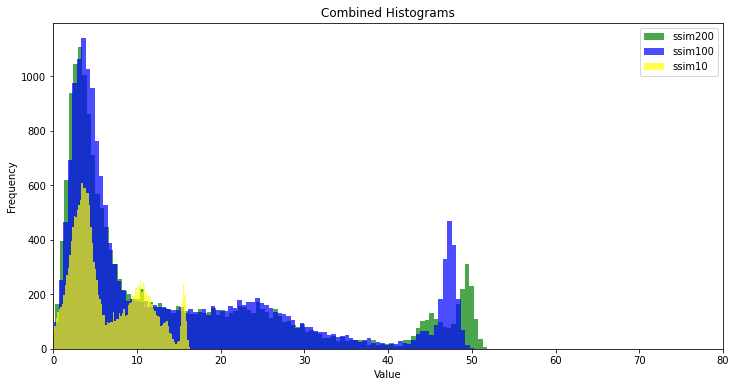

In [44]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms

#plt.hist(ssim_mod_400.flatten(), bins, alpha=0.7, label='ssim', color = 'red')
plt.hist(hpm_mod_for_200.flatten(), bins, alpha=0.7, label='ssim200', color = 'green')
plt.hist(hpm_mod_for_100.flatten(), bins, alpha=0.7, label='ssim100', color = 'blue')
plt.hist(hpm_mod_for_10.flatten(), bins, alpha=0.7, label='ssim10', color = 'yellow')

# Add a legend
plt.legend(loc='upper right')

plt.xlim(0,80)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



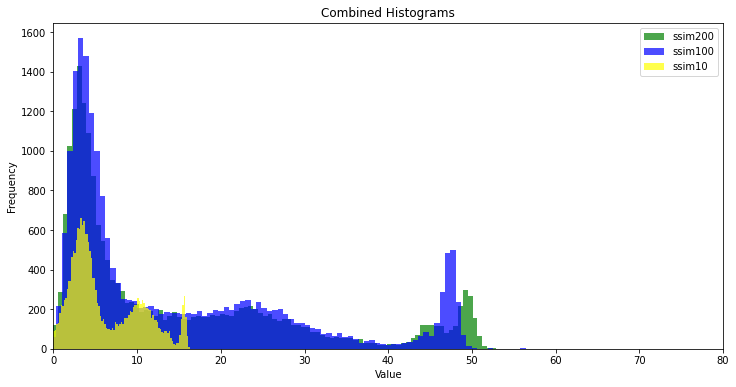

In [45]:
# Set the number of bins

fig, ax = plt.subplots(figsize=(12, 6))

bins = 100

# Create histograms

#plt.hist(ssim_mod_400.flatten(), bins, alpha=0.7, label='ssim', color = 'red')
plt.hist(hpm_mod_200.flatten(), bins, alpha=0.7, label='ssim200', color = 'green')
plt.hist(hpm_mod_100.flatten(), bins, alpha=0.7, label='ssim100', color = 'blue')
plt.hist(hpm_mod_10.flatten(), bins, alpha=0.7, label='ssim10', color = 'yellow')

# Add a legend
plt.legend(loc='upper right')

plt.xlim(0,80)

# Add titles and labels as needed
plt.title('Combined Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()



model vs sar forecast